In [29]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA' -O full_dataset.csv

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TdoIwEWGd9tj0A4SsbezdWFBOJoxrgfD' -O holidays.csv

--2021-03-04 19:41:53--  https://drive.google.com/uc?export=download&id=1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA
Resolving drive.google.com (drive.google.com)... 172.217.12.238, 2607:f8b0:4004:815::200e
Connecting to drive.google.com (drive.google.com)|172.217.12.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sghg673n0ldbkdreeb1hn4j0s8t53scb/1614886875000/05682749337820281666/*/1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA?e=download [following]
--2021-03-04 19:41:54--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sghg673n0ldbkdreeb1hn4j0s8t53scb/1614886875000/05682749337820281666/*/1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 172.217.7.193, 2607:f8b0:4004:801::2001
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.g

In [30]:
#@title Load Data

import pandas as pd

def load_full_dataset(path):
    """
    given a dataset with all business units
    return and write to each csv
    """
    df = pd.read_csv(path)
    
    df.rename(columns={'ACTIVITY DATE':'date', 
                       'Sum of TOTAL TIME - AHT (sec)':'handle_time', 
                       'Sum of TOTAL TIME - AHT - FORECAST (sec)': 'handle_time_forecast', 
                       'Sum of VOLUME - RECEIVED': 'volume', 
                       'Sum of VOLUME - FORECAST': 'volume_forecast', 
                       'Sum of VOLUME - HANDLED': 'volume_handled'}, inplace=True)
    
    df.columns = [x.lower() for x in df.columns]
    
    return df

path = '../content/full_dataset.csv'
df = load_full_dataset(path)
df.tail()

def write_data(df, group='business line', 
forecast_list=['handle_time','handle_time_forecast', 
'volume', 'volume_forecast', 'volume_handled']):
    """
    take in a dataframe, query by business unit 
    and write to a csv
    """
    # iterate through the unique business lines
    groups = df[group].unique()
    for line in groups:
        data = df[df[group] == line][['date']+forecast_list]

        path = '../content/'+line+'_aht_vol.csv'
        path = path.replace(' ', '-')
        data.to_csv(path)
        print('wrote to '+path)

write_data(df)

wrote to ../content/WISE-Contractual_aht_vol.csv
wrote to ../content/CS-Alaska_aht_vol.csv
wrote to ../content/CS-John-Hancock_aht_vol.csv
wrote to ../content/CS-Maryland_aht_vol.csv
wrote to ../content/CS-National_aht_vol.csv
wrote to ../content/RIS_aht_vol.csv
wrote to ../content/RCS-PHONES_aht_vol.csv
wrote to ../content/BRO_aht_vol.csv
wrote to ../content/PSG_aht_vol.csv
wrote to ../content/BRO-Complex_aht_vol.csv


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

def remove_holidays(df, path='../content/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

df = pd.read_csv("../content/RIS_aht_vol.csv", index_col=0, parse_dates=['date'])
df['aht'] = df['handle_time'] / df['volume_handled']
df['aht_forecast'] = df['handle_time_forecast'] / df['volume_forecast']
df.reset_index(drop=True, inplace=True)
df = remove_holidays(df)

volume = df[['date','volume']]
volume = volume.set_index('date')
handle_time = df[['date','handle_time']]
handle_time = handle_time.set_index('date')
aht = df[['date','aht']]
aht = aht.set_index('date')

print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1303, 8)


,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast
3,2016-01-04,3996279.0000,nan,6886.0000,6547.0000,6046.0000,660.9790,nan
4,2016-01-05,3175414.0000,nan,4928.0000,4328.0000,4715.0000,673.4706,nan
5,2016-01-06,2466037.0000,nan,3713.0000,3987.0000,3676.0000,670.8479,nan
6,2016-01-07,2529994.0000,nan,3910.0000,4006.0000,3862.0000,655.0994,nan
7,2016-01-08,2538784.0000,nan,3797.0000,4107.0000,3744.0000,678.0940,nan


In [32]:
df.rename(columns={'date': 'date_time'}, inplace=True)

In [33]:
df.set_index(df['date_time'], inplace=True)

In [34]:
# df = df.loc[:'2021-02',:].resample('MS').sum()

In [35]:
df['date_time'] = df.index

In [36]:
df.reset_index(drop=True, inplace=True)

In [37]:
df['year'] = df['date_time'].dt.year
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df = df.loc[:, ['date_time', 'volume','year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"] = df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

The time series starts from:  2016-01-04 00:00:00
The time series ends on:  2021-03-03 00:00:00


In [38]:
df['volume'] = df.loc[:,'volume'].fillna(0)

In [39]:
stat, p = stats.normaltest(df['volume'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=245.048, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 2.216888598719824
Skewness of normal distribution: 1.0726291199365425


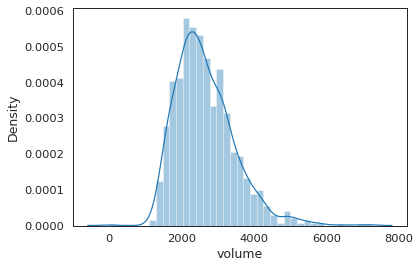

In [40]:
sns.distplot(df['volume']);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df['volume'])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df['volume'])))

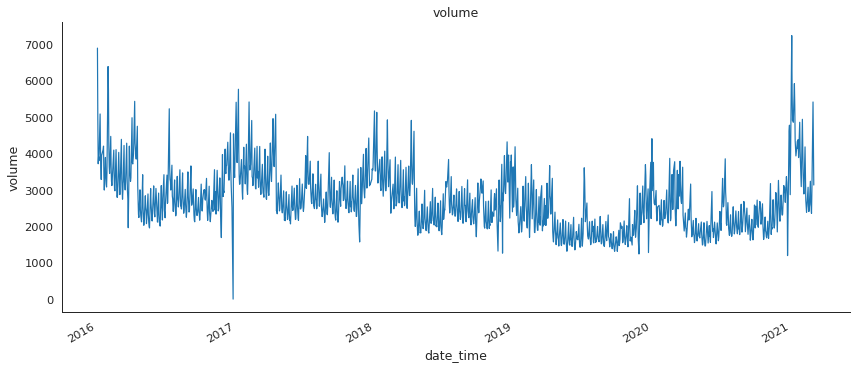

In [41]:
df1=df.loc[:,['date_time','volume']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('volume')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('volume')
sns.despine(top=True)
plt.show();

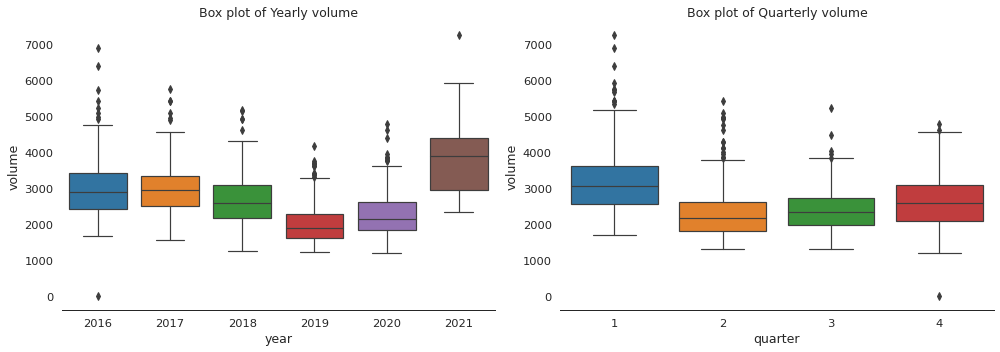

In [42]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="volume", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly volume')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="volume", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly volume')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
volume,1303.0000,2649.9225,814.1405,0.0000,2078.0000,2528.0000,3106.5000,7230.0000


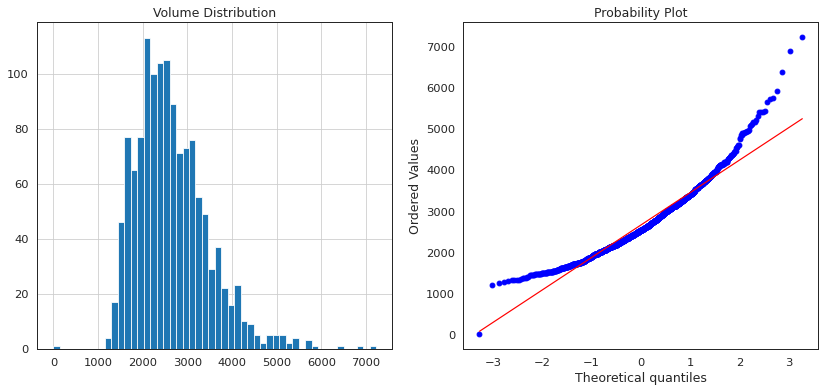

In [43]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.subplot(1,2,2)
stats.probplot(df['volume'], plot=plt);
df1.describe().T

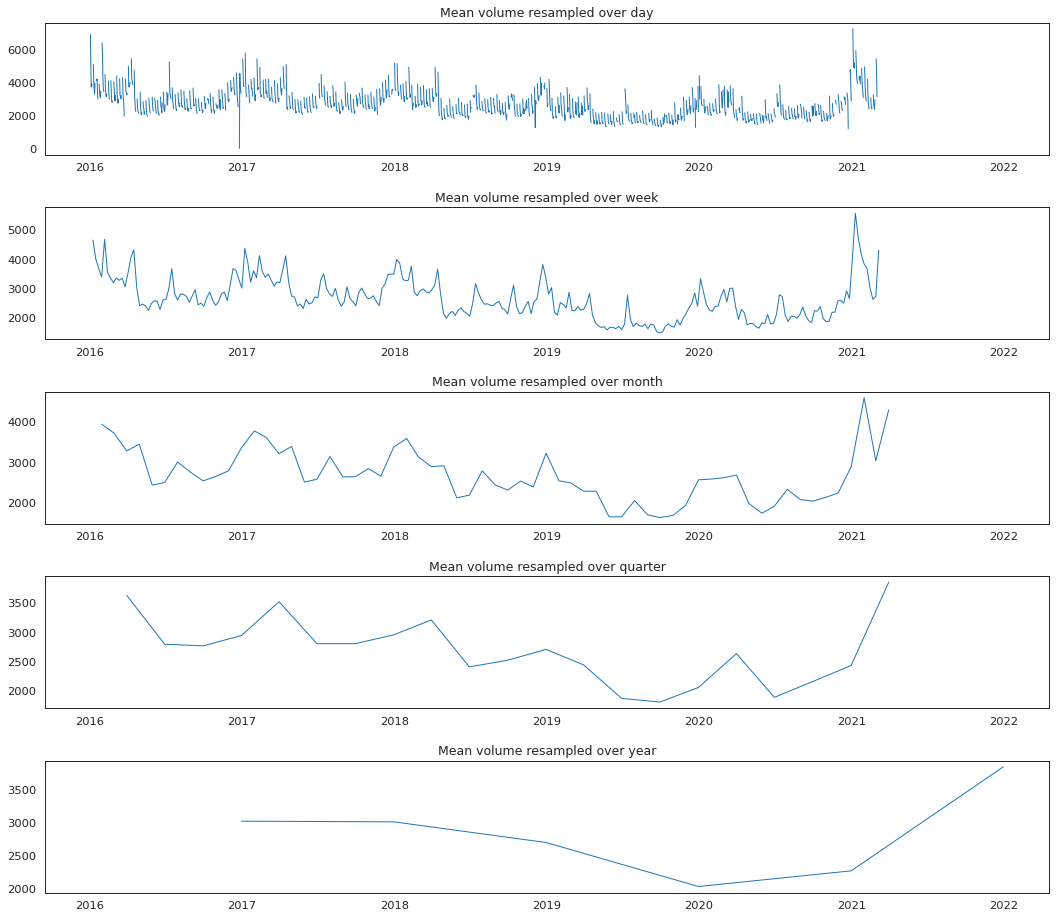

In [44]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['volume'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean volume resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['volume'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean volume resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['volume'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean volume resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['volume'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean volume resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['volume'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean volume resampled over year')
ax5.tick_params(axis='both', which='major');

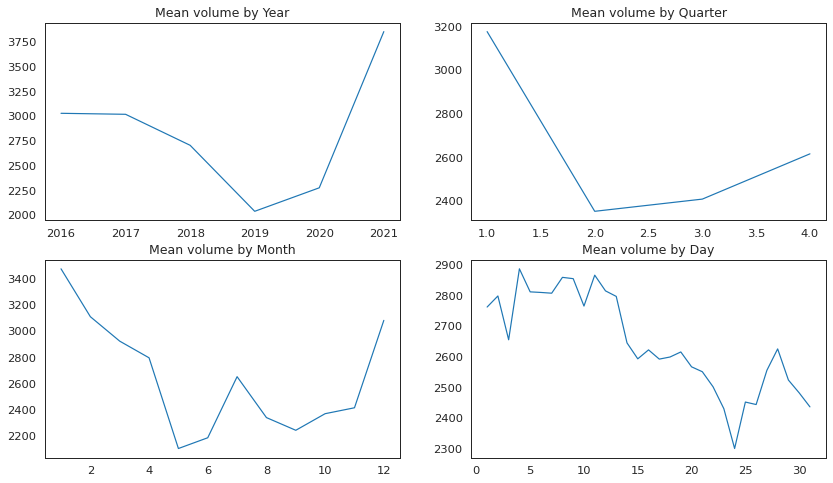

In [45]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year')['volume'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean volume by Year')

plt.subplot(2,2,2)
df.groupby('quarter')['volume'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean volume by Quarter')

plt.subplot(2,2,3)
df.groupby('month')['volume'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean volume by Month')

plt.subplot(2,2,4)
df.groupby('day')['volume'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean volume by Day');


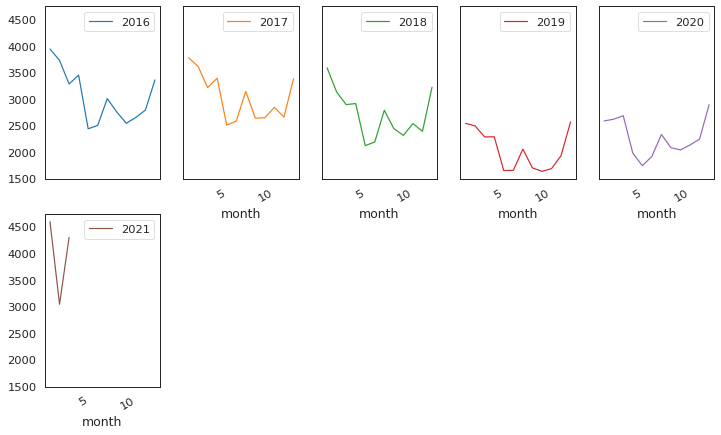

In [46]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "volume", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

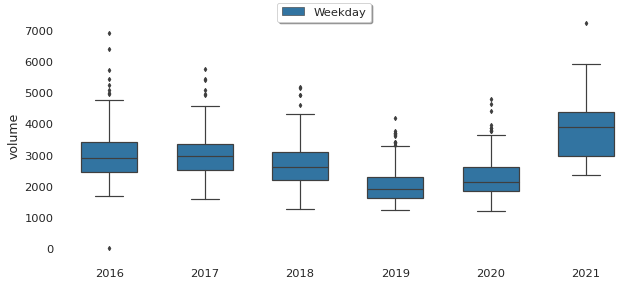

In [47]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','volume',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

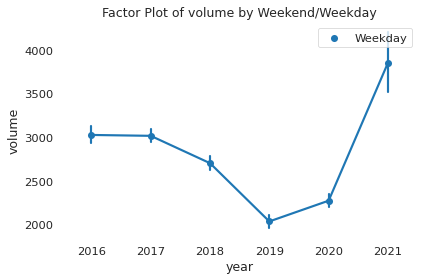

In [48]:
plt1=sns.factorplot('year','volume',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of volume by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

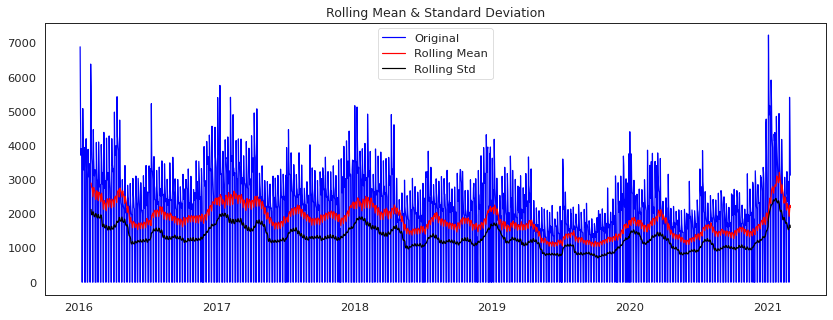

<Results of Dickey-Fuller Test>
Test Statistic                  -3.9464
p-value                          0.0017
#Lags Used                      22.0000
Number of Observations Used   1863.0000
Critical Value (1%)             -3.4339
Critical Value (5%)             -2.8631
Critical Value (10%)            -2.5676
dtype: float64


In [49]:
df2=df1.resample('D').sum()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2['volume'].dropna())

In [50]:
dataset = df['volume'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [51]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 0.1578 - val_loss: 0.0772
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0973 - val_loss: 0.0405
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0528 - val_loss: 0.0182
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0236 - val_loss: 0.0106
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0105
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0107
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 8/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 9/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 10/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 11/20
15/15 

In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
print('test mape:', mean_absolute_percentage_error(Y_test[0], test_predict[:,0]))

Train Mean Absolute Error: 458.89463165046874
Train Root Mean Squared Error: 611.7852865374136
Test Mean Absolute Error: 520.726591268329
Test Root Mean Squared Error: 691.9986124754314
Test Root Mean Squared Error: 691.9986124754314
test mape: 22.098570761218404


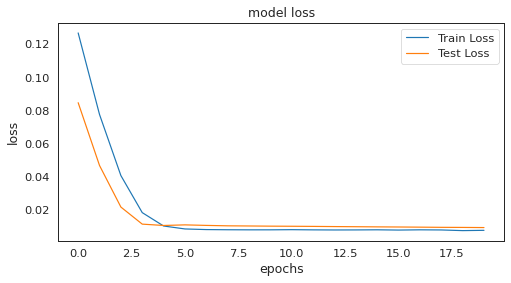

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

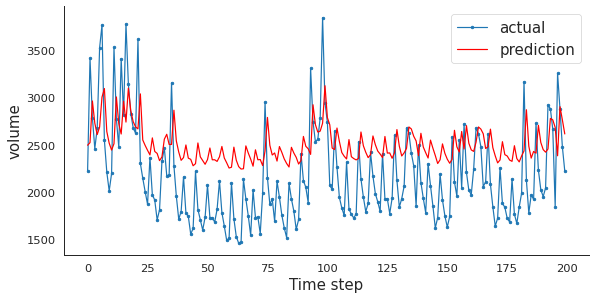

In [26]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [27]:
Y_test.shape

(1, 259)